In [1]:
# Add the directory containing api_connection.py to the system path
import sys
import os
from pathlib import Path
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
sys.path.append(str(Path.cwd() / "bachelor_thesis"))
from api_connection import QiskitService
from qiskit_aer import AerSimulator  # For simulation comparison

# Load the IBM Quantum Runtime service

NUM_SHOTS = 500

#backend = AerProvider().get_backend("qasm_simulator")
backend = QiskitService(str(Path.cwd() / ".env")).get_least_busy_backend()


Connected to IBM Quantum.


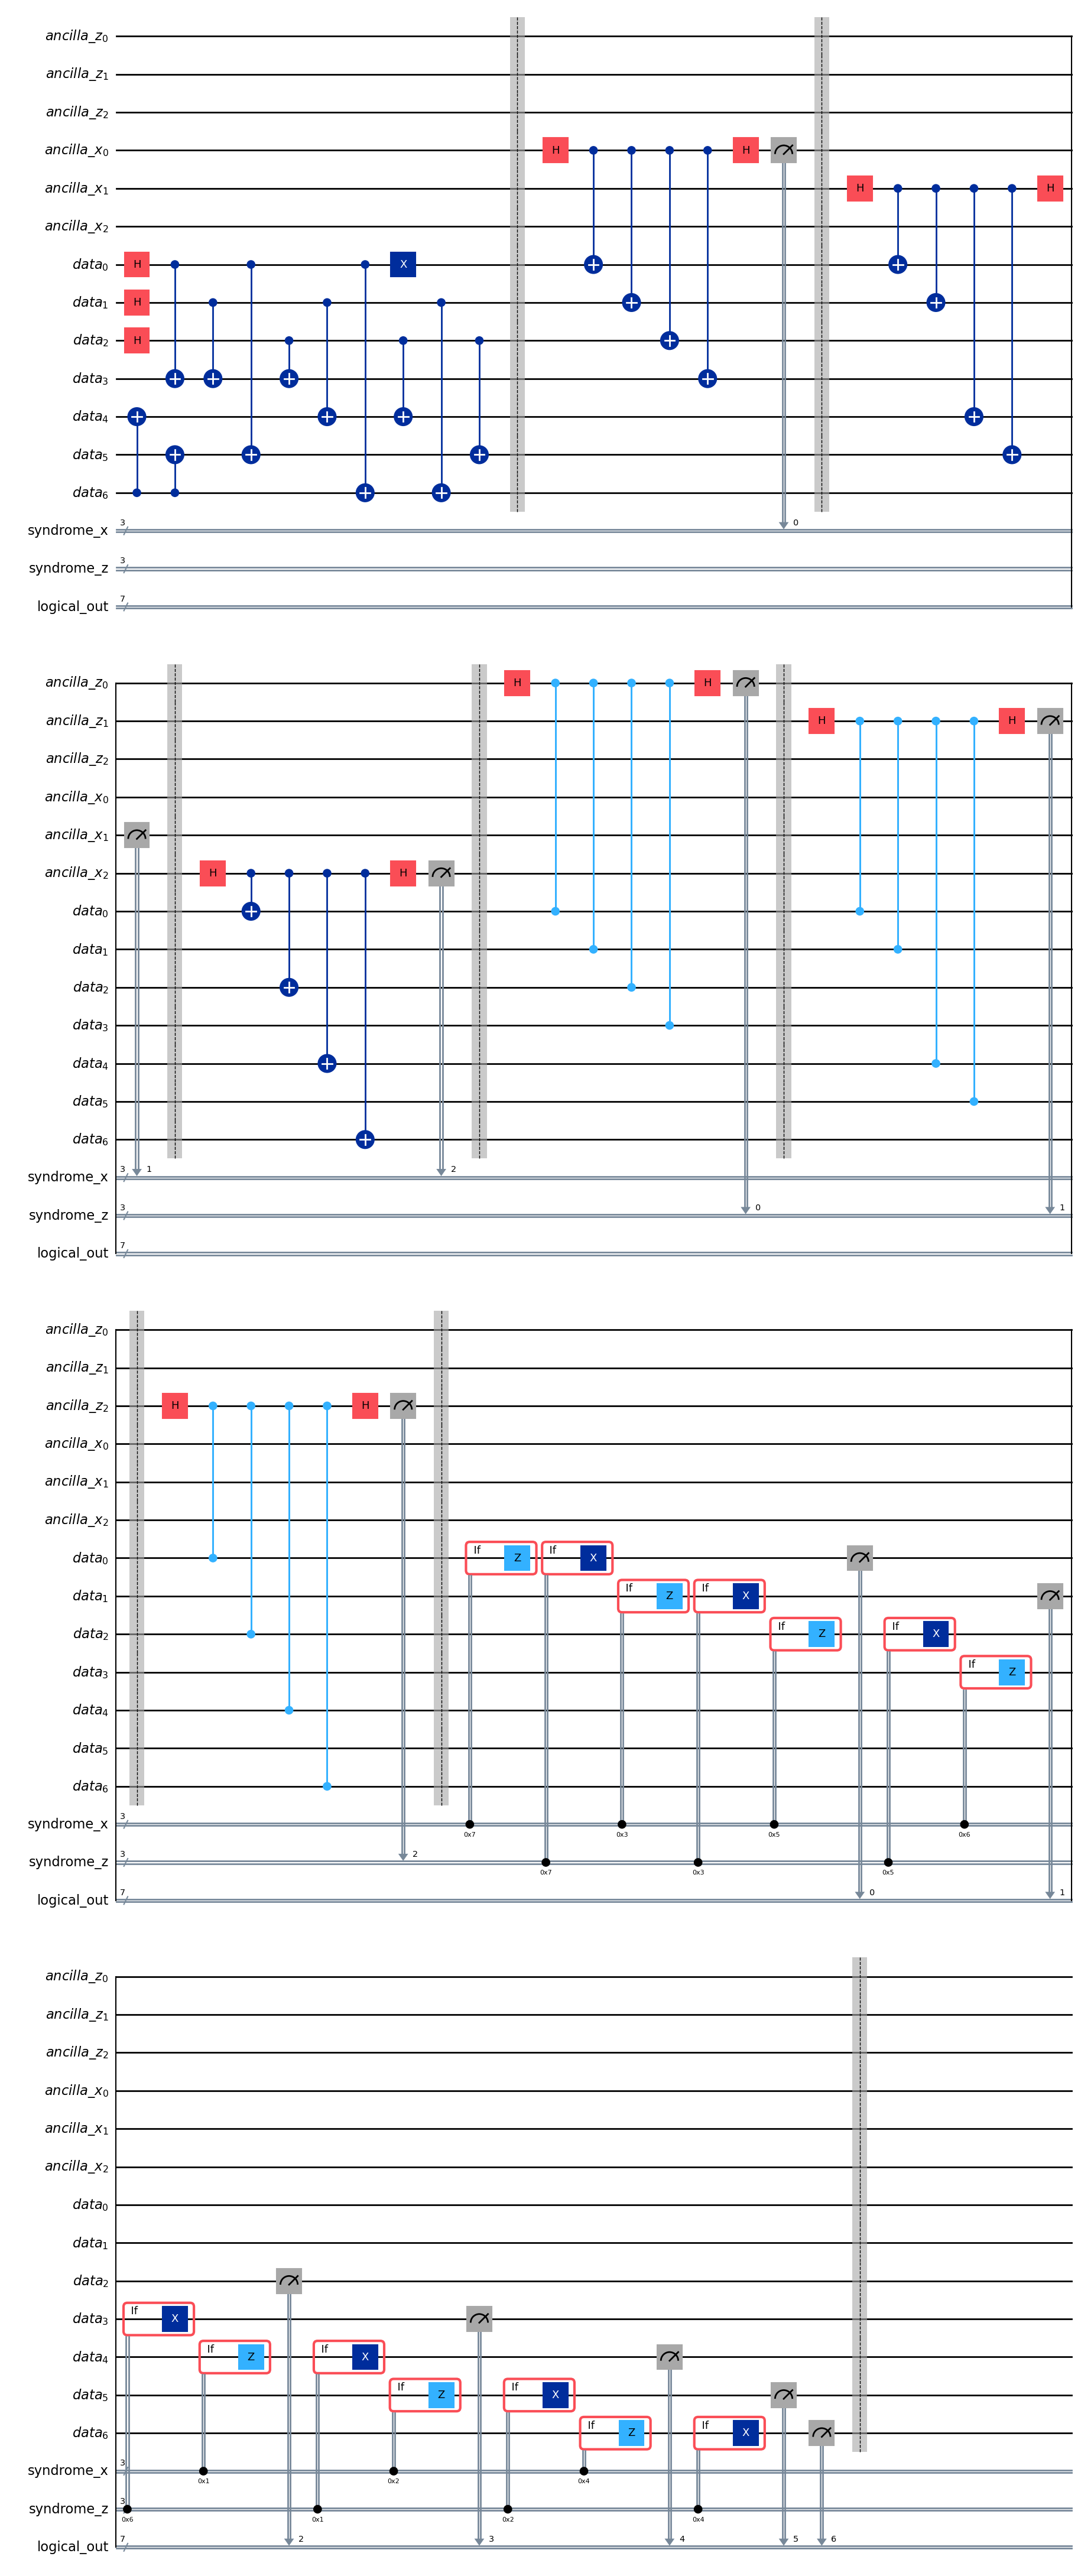

In [ ]:
barrierBit = 0
data = QuantumRegister(7, 'data')
ancilla_x = QuantumRegister(3, 'ancilla_x')
ancilla_z = QuantumRegister(3, 'ancilla_z')
syndrome_x = ClassicalRegister(3, 'syndrome_x')
syndrome_z = ClassicalRegister(3, 'syndrome_z')
logical_out = ClassicalRegister(7, 'logical_out')

circuit = QuantumCircuit(ancilla_z, ancilla_x, data, syndrome_x, syndrome_z, logical_out)

# Encoding for |0_L>
circuit.h(data[0])
circuit.h(data[1])
circuit.h(data[2])
circuit.cx(data[6], data[4])

circuit.cx(data[6], data[5])
circuit.cx(data[0], data[3])
circuit.cx(data[1], data[3])
circuit.cx(data[0], data[5])
circuit.cx(data[2], data[3])
circuit.cx(data[1], data[4])
circuit.cx(data[0], data[6])
circuit.cx(data[2], data[4])
circuit.cx(data[1], data[6])
circuit.cx(data[2], data[5])


circuit.x(data[0])
#circuit.z(data[0])

circuit.barrier()
stabilizers_x = [(0,1,2,3), (0,1,4,5), (0,2,4,6)]
for i, (q0, q1, q2, q3) in enumerate(stabilizers_x):
    circuit.h(ancilla_x[i])
    # Reverse the control-target order for the CNOT gates:
    circuit.cx(ancilla_x[i], data[q0])
    circuit.cx(ancilla_x[i], data[q1])
    circuit.cx(ancilla_x[i], data[q2])
    circuit.cx(ancilla_x[i], data[q3])
    circuit.h(ancilla_x[i])
    circuit.measure(ancilla_x[i], syndrome_x[i])
    circuit.barrier()


# Z stabilizer measurement
stabilizers_z = [(0,1,2,3), (0,1,4,5), (0,2,4,6)]
for i, (q0, q1, q2, q3) in enumerate(stabilizers_z):
    circuit.h(ancilla_z[i])
    circuit.cz(data[q0], ancilla_z[i])
    circuit.cz(data[q1], ancilla_z[i])
    circuit.cz(data[q2], ancilla_z[i])
    circuit.cz(data[q3], ancilla_z[i])
    circuit.h(ancilla_z[i])
    circuit.measure(ancilla_z[i], syndrome_z[i])
    circuit.barrier()

corrections = [
    (0b111, 0),  # Qubit 0 -> Syndrome 111
    (0b011, 1),  # Qubit 1 -> Syndrome 011
    (0b101, 2),  # Qubit 2 -> Syndrome 101
    (0b001, 3),  # Qubit 3 -> Syndrome 001 
    (0b110, 4),  # Qubit 4 -> Syndrome 110
    (0b010, 5),  # Qubit 5 -> Syndrome 010
    (0b100, 6)   # Qubit 6 -> Syndrome 100
]

# Correct for phase-flip (Z) errors using the syndrome from the X stabilizers.
for pattern, qubit in corrections:
    with circuit.if_test((syndrome_x, pattern)):
        circuit.z(data[qubit])
    with circuit.if_test((syndrome_z, pattern)):
        circuit.x(data[qubit])


for i in range(7):
    circuit.measure(data[i], logical_out[i])
circuit.barrier()


circuit.draw(output='mpl')

In [3]:
# Simulation parameters
simulator = AerSimulator()  # Try default simulator first
NUM_SHOTS = 5000
classic_job = simulator.run(circuit, shots=NUM_SHOTS)
classic_result = classic_job.result()
counts = classic_result.get_counts()
CodeWord = list(counts.keys())

print(CodeWord)

['0111100 111 000', '1010101 111 000', '1011010 111 000', '0001111 111 000', '0110011 111 000', '0000000 111 000', '1101001 111 000', '1100110 111 000']


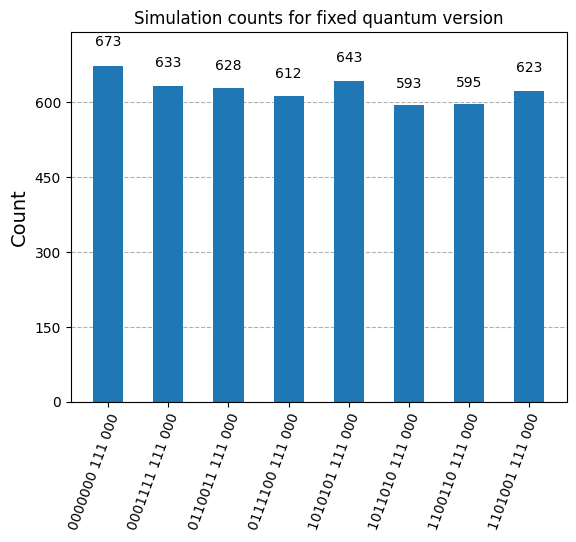

In [4]:
plot_histogram(classic_result.get_counts(), title='Simulation counts for fixed quantum version')

* Classic error correcting version down below

In [5]:
# Set up the preset pass manager with optimization level 0
preset_manager = generate_preset_pass_manager(backend)# optimization_level=3)
preset_circuit = preset_manager.run(circuit)

# Run the circuit using the Sampler
job = Sampler(mode=backend).run([(preset_circuit)], shots=NUM_SHOTS)
print(f"Job ID: {job.job_id()}, \n Job Status: {job.status()}")

Job ID: czv7npynhqag008t76q0, 
 Job Status: QUEUED


In [6]:
# Get and display results
result = job.result()
pub_result = result[0]
#syndromme x finds phase flips
print(f"Counts for the 'sx' output register: {pub_result.data.syndrome_x.get_counts()}")
#syndrome z finds bit flips
print(f"Counts for the 'sz' output register: {pub_result.data.syndrome_z.get_counts()}")

#syndrome z finds bit flips
print(f"Counts for the 'logical_out' output register: {pub_result.data.logical_out.get_counts()}")

Counts for the 'sx' output register: {'010': 597, '011': 633, '111': 648, '110': 606, '100': 617, '000': 609, '001': 672, '101': 618}
Counts for the 'sz' output register: {'100': 626, '011': 641, '111': 633, '000': 595, '010': 629, '001': 601, '110': 610, '101': 665}
Counts for the 'logical_out' output register: {'1101000': 44, '0111011': 28, '0111111': 31, '0010111': 37, '0011111': 32, '0100101': 34, '1101101': 30, '0011001': 59, '1010010': 31, '0111010': 29, '0000000': 64, '1000101': 35, '1111011': 29, '0010101': 43, '0011000': 49, '0000001': 58, '0100000': 54, '0000101': 42, '0000011': 57, '0100111': 38, '1010011': 55, '1000000': 62, '0100001': 47, '1000011': 47, '1100011': 35, '0000100': 51, '0110000': 41, '0011011': 42, '1101011': 32, '0001100': 43, '0001011': 48, '1000010': 50, '1110101': 36, '1100101': 38, '0010010': 59, '1011010': 44, '0010001': 59, '0101101': 38, '1100000': 44, '0100010': 52, '0110111': 24, '0011010': 38, '0101111': 36, '1001100': 30, '1010111': 35, '1001011':

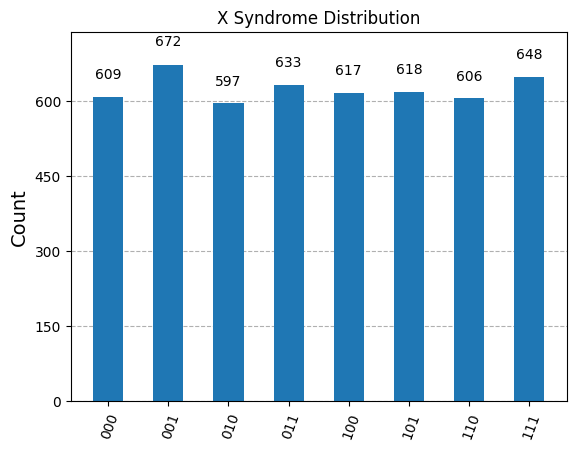

In [7]:

# Optional: Visualize the syndrome distributions
plot_histogram(pub_result.data.syndrome_x.get_counts(), title="X Syndrome Distribution")

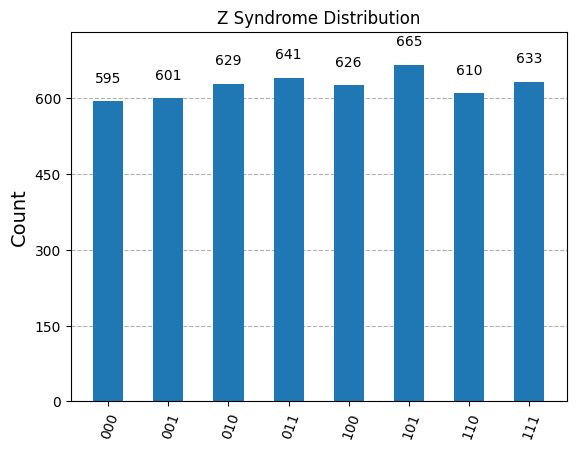

In [8]:
plot_histogram(pub_result.data.syndrome_z.get_counts(), title="Z Syndrome Distribution")


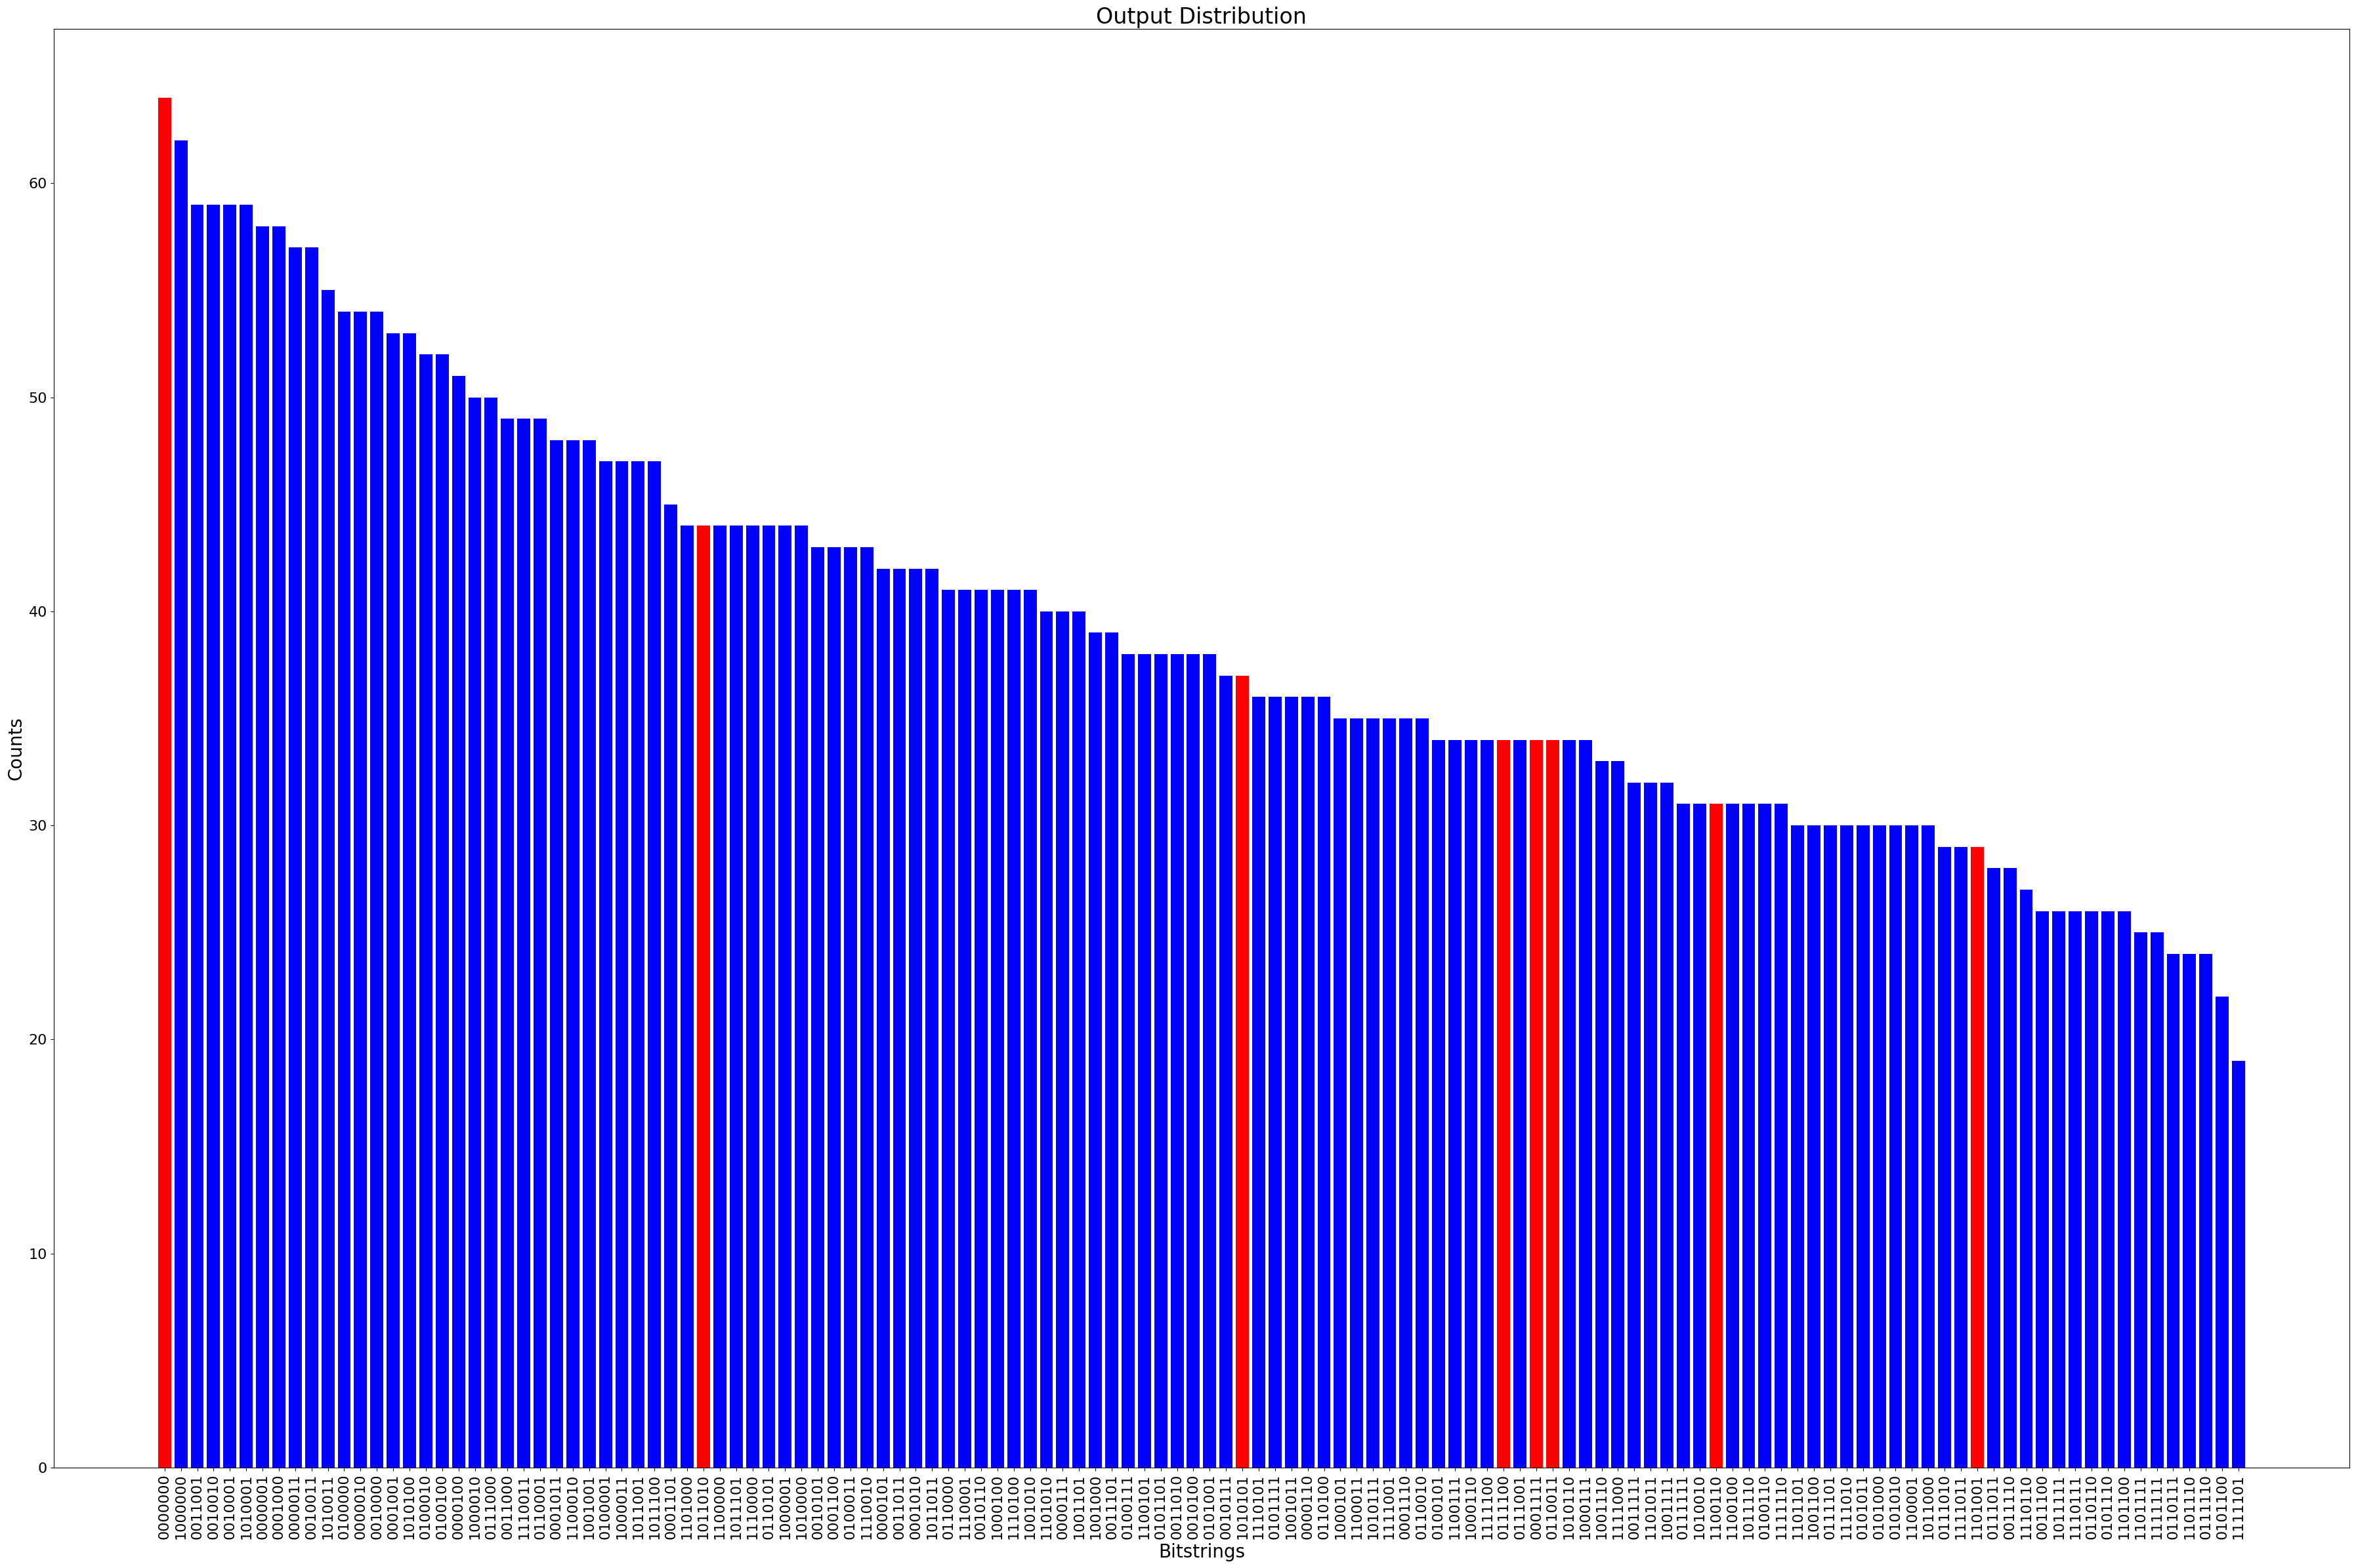

In [9]:
import matplotlib.pyplot as plt

steane_code_logic_0 = {"0000000", "1010101", "0110011", "1100110", 
                       "0001111", "1011010", "0111100", "1101001"}

# Get the counts data
counts = pub_result.data.logical_out.get_counts()

# Sort the counts for better visualization
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Prepare data for plotting
keys = list(sorted_counts.keys())
values = list(sorted_counts.values())
colors = [
    "red" if key in steane_code_logic_0 
    else "blue" 
    for key in keys
]
# Create the bar chart
plt.figure(figsize=(36, 24))
plt.bar(keys, values, color=colors)

# Add labels and title
plt.xlabel("Bitstrings", fontsize=20)
plt.ylabel("Counts", fontsize=20)
plt.title("Output Distribution", fontsize=24)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

In [10]:
# Calculate the total counts for the desired states in steane_code_logic_0
desired_counts = sum(counts[key] for key in steane_code_logic_0 if key in counts)

# Print the result
print(f"Total counts for desired states in steane_code_logic_0: {desired_counts}")

# Calculate the percentage of desired states
percentage = (desired_counts / NUM_SHOTS) * 100
print(f"Percentage of desired states: {percentage:.2f}%")

# Calculate the number of distinct values encountered
distinct_values = len(counts)
print(f"Number of distinct values encountered: {distinct_values}")

Total counts for desired states in steane_code_logic_0: 307
Percentage of desired states: 6.14%
Number of distinct values encountered: 128
